In [3]:
import lsdb
import numpy as np
import sys
import pandas as pd
from astropy.coordinates import SkyCoord
sys.path.append('../src')

import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

pd.set_option('display.max_columns', None)

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

CPU times: user 10.4 s, sys: 2.42 s, total: 12.8 s
Wall time: 15 s


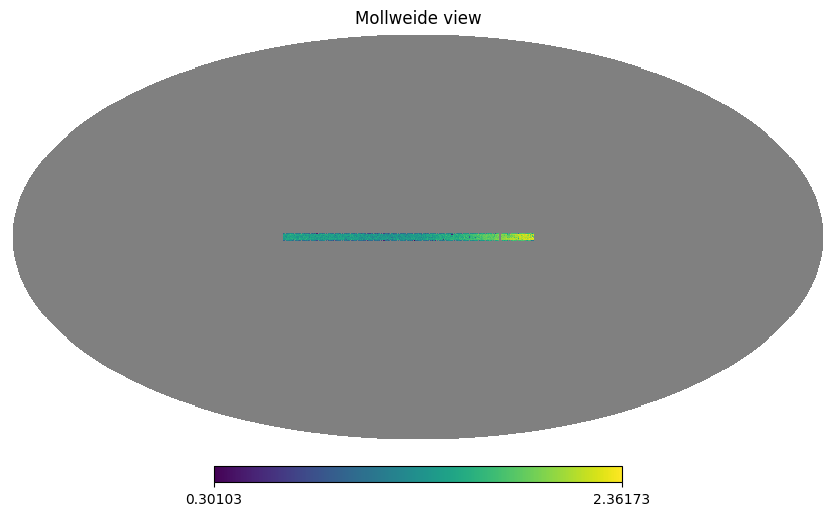

In [4]:
%%time 
s82 = lsdb.read_hipscat("/mnt/beegfs/scratch/data/S82_standards/S82_hipscat_fixed/")
s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

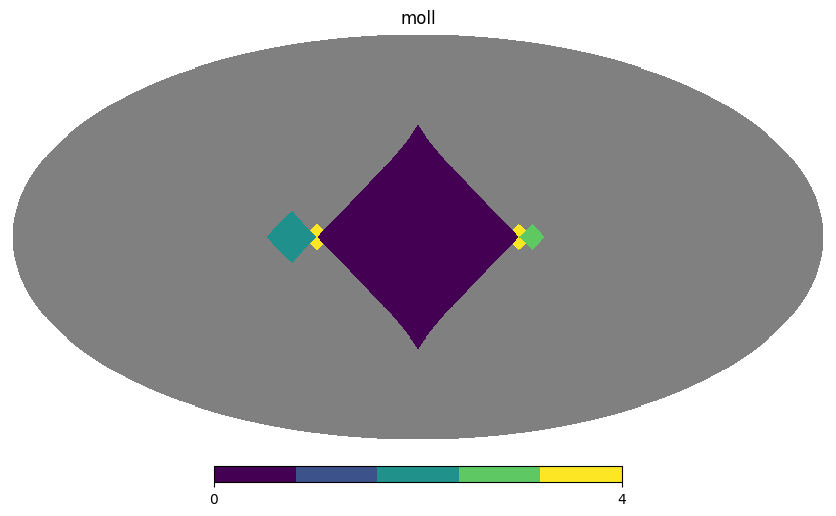

In [5]:
s82.plot_pixels()

Change some column names and add some columns (needed later on), and apply the gi cut.

Next, read the stellar locus parametrization.

In [6]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False) # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

In [17]:
OKlocus

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424
-0.98,-2.5,1.3782,0.5772,0.2645,0.1676,0.0801,0.8417000000000001
-0.97,-2.5,1.377,0.5768,0.2643,0.1674,0.08,0.8411
-0.96,-2.5,1.3758,0.5764,0.264,0.1672,0.0799,0.8404
-0.95,-2.5,1.3747,0.5759,0.2638,0.167,0.0798,0.8396999999999999
-0.94,-2.5,1.3735,0.5755,0.2635,0.1668,0.0797,0.839
-0.93,-2.5,1.3724,0.5751,0.2632,0.1665,0.0796,0.8382999999999999
-0.92,-2.5,1.3712,0.5747,0.263,0.1663,0.0795,0.8377


Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [7]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [29]:
catalog = s82
fitColors = ('ug', 'gr', 'ri', 'iz')
priorsRootName = 'results/S82_priors/5/0'
outfile = 'results/S82_Bayes_estimates.txt'

Make 3D locus list with three ArGrid limits and resolutions.

In [9]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [18]:
iStart = 0
iEnd = 250 # if<0: do all stars
# myStars = [0, 100, 1000, 10000] # for illustration, make plots for these stars
myStars = [10, 233] # no plots
verb=True

In [22]:
df = catalog.pixel_search([(5,0)]).compute()
df.Mr*0.0

_hipscat_index
715281479499776    -0.0
715101011181568    -0.0
714770441306112    -0.0
712559007105024    -0.0
713770364043264    -0.0
                   ... 
360351065440256    -0.0
369597584769024    -0.0
383946068066304    -0.0
1127069186523136   -0.0
377537611956224    -0.0
Name: Mr, Length: 3981, dtype: double[pyarrow]

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
working on star 0
pts: 25 155


/home/scampos/photoD/notebooks/../src/BayesTools.py:1070: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['chi2min'][i] = np.min(chi2map)
/home/scampos/photoD/notebooks/../src/BayesTools.py:1102: FutureWarning: ChainedAssignmentError: 

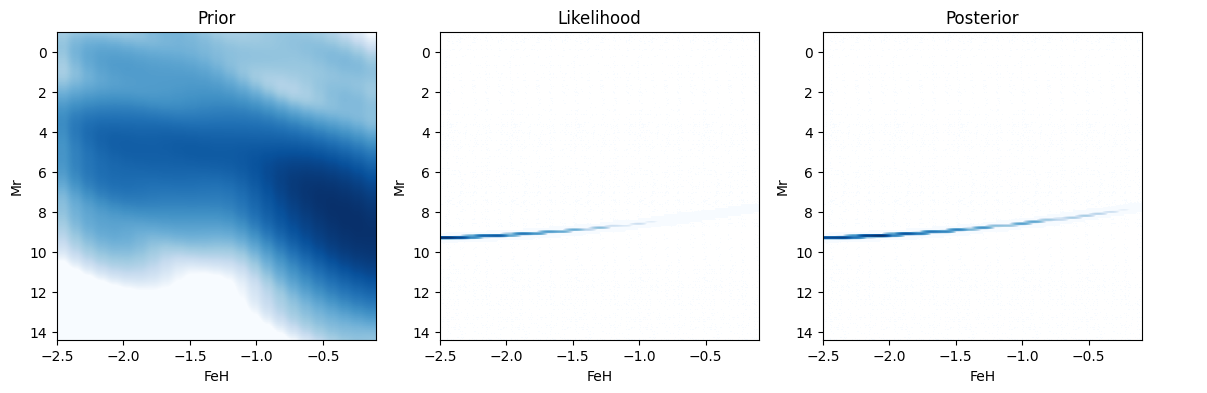

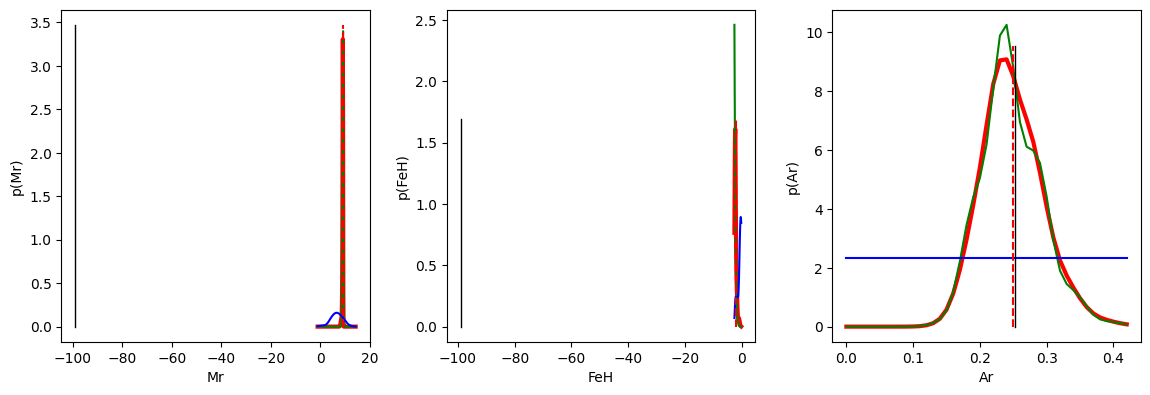

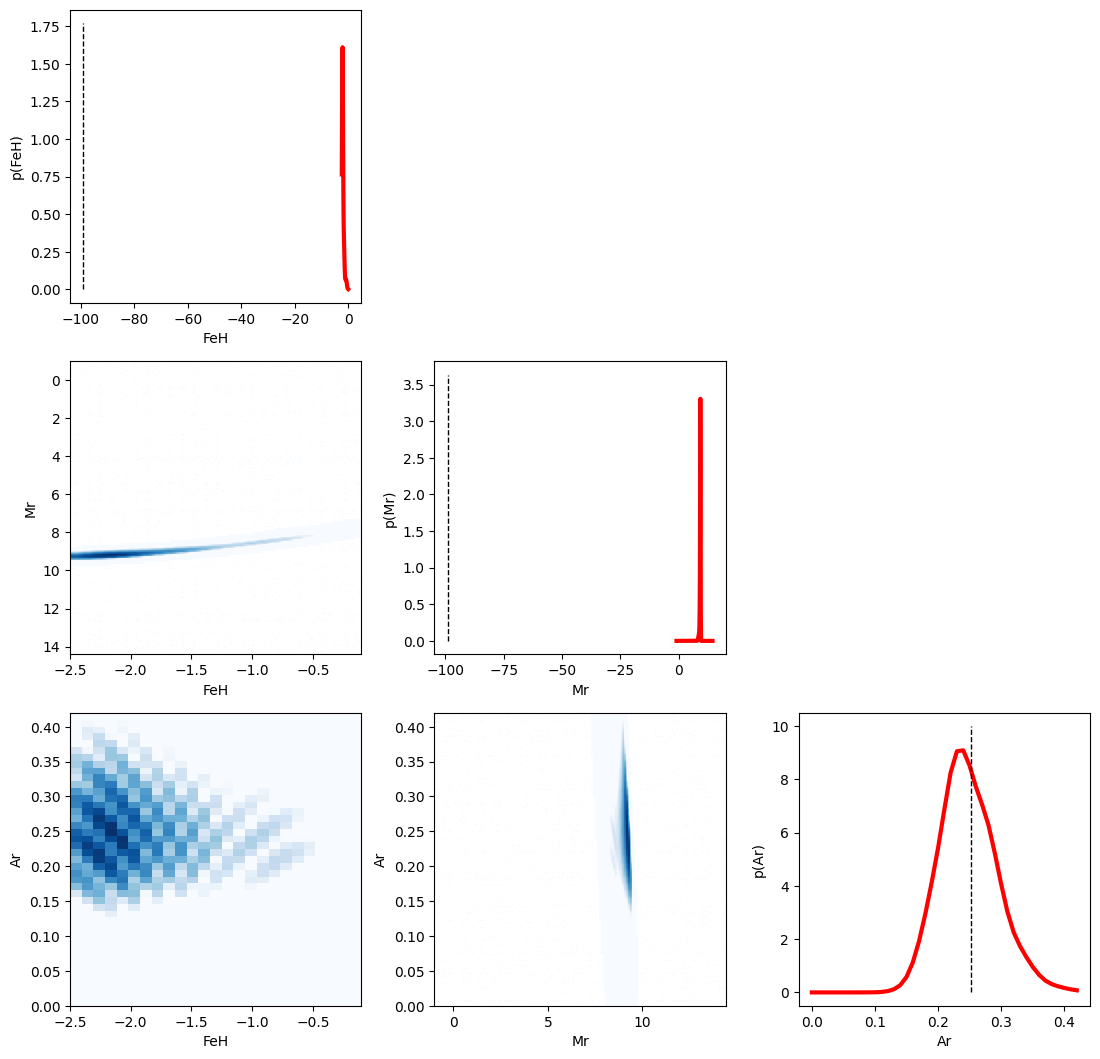

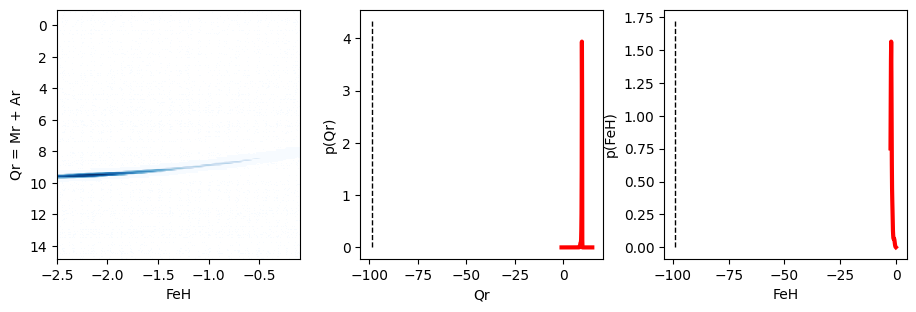

/home/scampos/photoD/notebooks/../src/BayesTools.py:1122: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['QrEst'][i], catalog['QrEstUnc'][i] = getStats(Qr1d, margpostQr)


 *** 3D Bayes results for star i= 10
r mag: 19.142 g-r: 1.3960000000000008 chi2min: 6.800323779672715
Mr: true= -99 estimate= 9.138824413020695  +-  0.19646970949218703
FeH: true= -99 estimate= -2.065100530379611  +-  0.37449133184173766
Ar: true= 0.253 estimate= 0.24887466924448082  +-  0.04622121888782563
Qr: true= -98.747 estimate= 9.434634090698186  +-  0.18951420558820828
Mr drop in entropy: -40.61831825437979
FeH drop in entropy: -7.810736535914073
Ar drop in entropy: -119.25757846790219
pts: 25 155


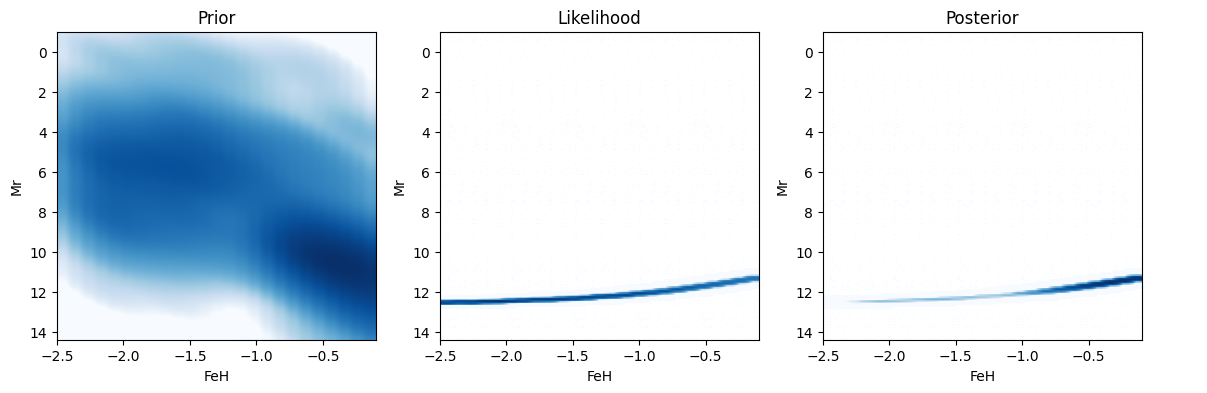

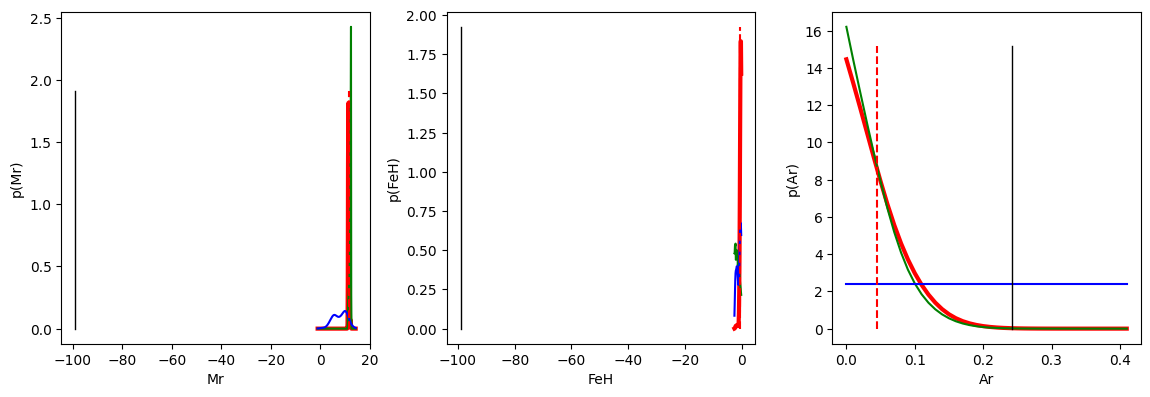

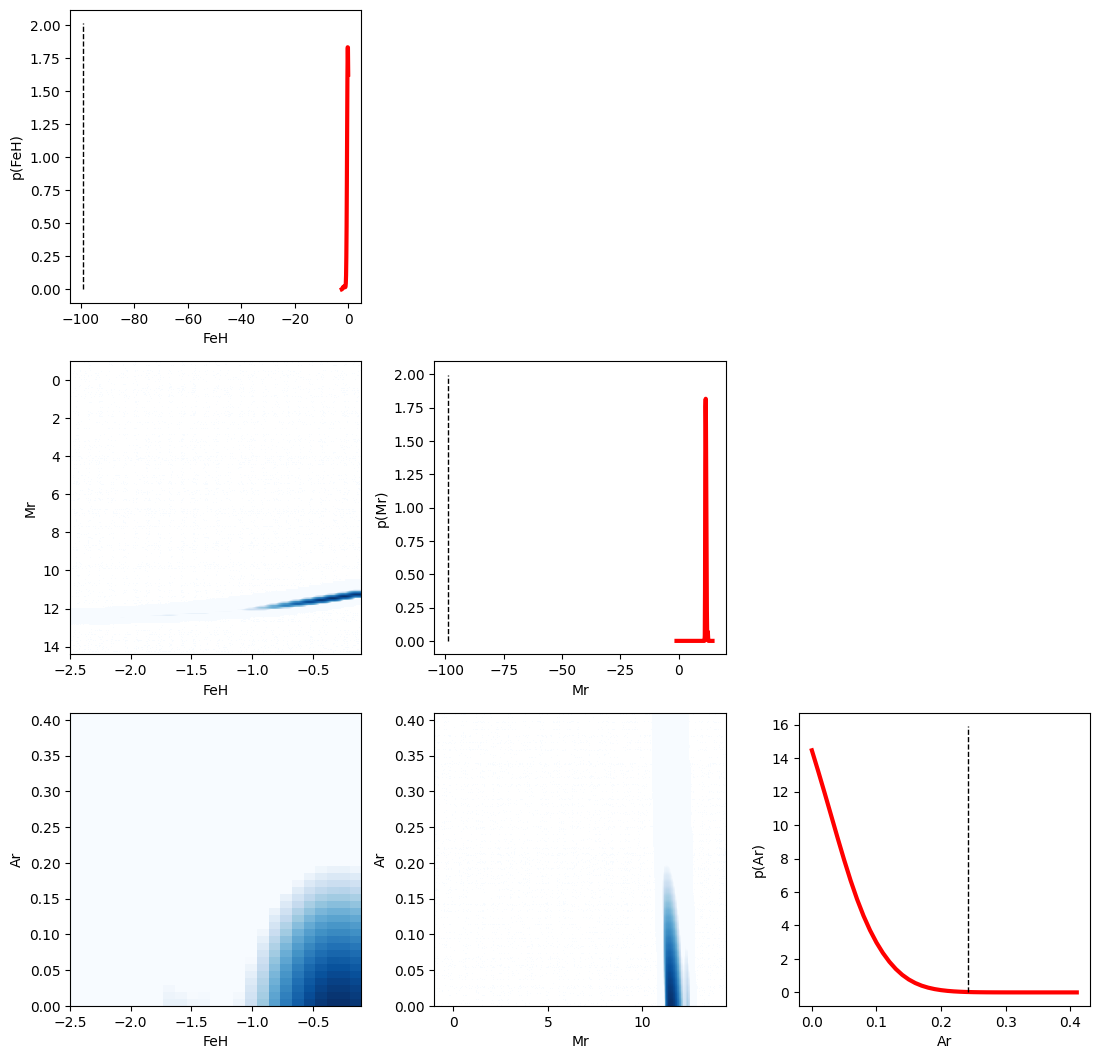

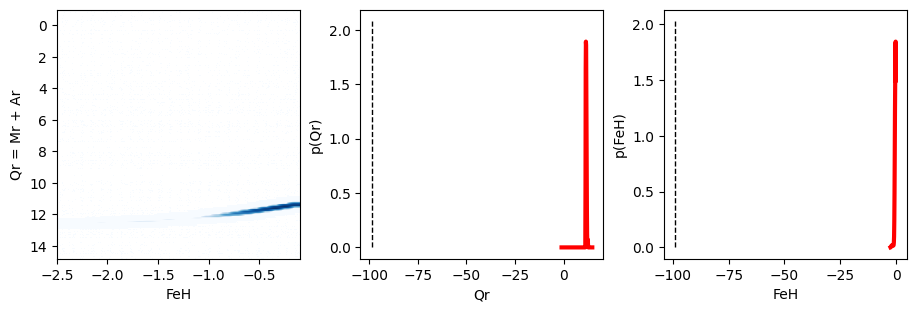

 *** 3D Bayes results for star i= 233
r mag: 21.444 g-r: 1.3840000000000003 chi2min: 4.670120281545206
Mr: true= -99 estimate= 11.561513769872535  +-  0.227858992031677
FeH: true= -99 estimate= -0.38284686726220873  +-  0.273400214341876
Ar: true= 0.242 estimate= 0.044935684737796175  +-  0.04072354527950865
Qr: true= -98.758 estimate= 11.653415329306807  +-  0.22264909559232351
Mr drop in entropy: -36.88185735192782
FeH drop in entropy: -14.825538085257136
Ar drop in entropy: -166.5934988933368
CPU times: user 7.57 s, sys: 1.09 s, total: 8.65 s
Wall time: 6.46 s


In [30]:
%%time
bt.makeBayesEstimates3D(df.reset_index(drop=True), fitColors, locusData, locus3DList, ArGridList, 
                        priorsRootName, outfile, iStart, iEnd, myStars, verbose=verb)